# HANC with a Welfare State

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test: Solving and simulating the household problem](#toc2_)    
- 3. [Find stationary equilibrium](#toc3_)    
- 4. [Expected discounted utility](#toc4_)       
- 5. [Find transition path](#toc5_)
- 6. [Policy functions](#toc6_)

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [19]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [20]:
model = HANCWelfareModelClass(name='baseline')

In [21]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [22]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.chi = 0.0
ss.S = 0.0
ss.tau = 0.015

We can now solve and simulate:

In [23]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 1.2 secs [345 iterations]


In [24]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 0.2 secs [399 iterations]


And we can check whether the results make sort of sense:

In [25]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

model.ss.A_hh = 2.02
model.ss.L_hh = 1.06
model.ss.C_hh = 0.78


## 3. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

In [66]:
ss.G = 0.3199
ss.chi = 0.0

In [67]:
model.find_ss(do_print=True)

starting at KL=3.8624
starting at LY=0.9016

 message: The solution converged.
 success: True
  status: 1
     fun: [-8.299e-11 -4.519e-12]
       x: [ 3.521e+00  5.817e-01]
    nfev: 13
    fjac: [[-9.994e-01 -3.565e-02]
           [ 3.565e-02 -9.994e-01]]
       r: [-5.536e+00 -8.623e+00  1.193e+00]
     qtf: [ 8.092e-09  1.522e-10]

steady state found in 19.9 secs
ss.K =  2.048
ss.A_hh =  2.048
ss.Y =  0.849
ss.r =  0.024
ss.w =  1.021
ss.G =  0.320
ss.LG =  0.320
ss.LY =  0.582
ss.tau =  0.571
ss.clearing_A = -8.30e-11
ss.clearing_L = -4.52e-12
ss.clearing_Y = -5.55e-17


In [43]:
model.info(only_blocks=True,ss=True)

production_firm: [K=2.17,LY=0.61] -> [rK=0.12,w=1.02,Y=0.90]
mutual_fund: [K=2.17,rK=0.12] -> [A=2.17,r=0.02]
government: [w=1.02,G=0.30,LY=0.61,chi=-0.01] -> [tau=0.54,wt=0.47,LG=0.30,L=0.91,S=0.30,B=0.00]
hh: [S=0.30,chi=-0.01,r=0.02,tau=0.54,wt=0.47] -> [A_hh=2.17,C_hh=0.38,ELL_hh=0.97,L_hh=0.91,INC_hh=0.48,U_hh=-6.23]
market_clearing: [A=2.17,A_hh=2.17,LY=0.61,LG=0.30,L_hh=0.91,L=0.91,Y=0.90,C_hh=0.38,K=2.17,G=0.30] -> [I=0.22,clearing_A=-0.00,clearing_L=0.00,clearing_Y=0.00]


## 4. <a id='toc9_'></a>[Expected discounted utility](#toc0_)

In [68]:
V_hh_ss = np.sum([par.beta**t*ss.U_hh for t in range(par.T)])
print(f'Expected discounted utility with ss.G = {ss.G}, ss.LG = {ss.LG}, ss.chi = {ss.chi}:')
print(f'{V_hh_ss:.4f}')

Expected discounted utility with ss.G = 0.3199, ss.LG = 0.3199, ss.chi = 0.0:
-153.9826


In [53]:
def optimize_welfare_policies(model, par, ss, Gamma_Y_values):
    results = {}

    for Gamma_Y in Gamma_Y_values:
        par.Gamma_Y = Gamma_Y

        def target(x):
            # x[0] is G, x[1] is chi
            G = x[0]
            chi = x[1]
            
            # Use the relationship G = Gamma_G * LG
            # LG = G / par.Gamma_G
            
            # Update the model with these values
            ss.G = G
            # ss.LG = LG
            ss.chi = chi
            model.find_ss(do_print=False)
            
            return -ss.U_hh

        # Optimize G and chi
        initial_guess = [0.1, 0.0]  # Example initial guesses for G and chi
        bounds = [(0.0, 0.4), (-0.01, 0.0005)]  # Example bounds for G and chi
        res = optimize.minimize(target, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        optimal_G = res.x[0]
        optimal_chi = res.x[1]
        # optimal_LG = optimal_G / par.Gamma_G

        # Update model with the optimal values
        ss.G = optimal_G
        ss.chi = optimal_chi
        # ss.LG = optimal_LG
        model.find_ss(do_print=True)
        
        # Compute additional results
        V_hh_ss = np.sum([par.beta**t * ss.U_hh for t in range(par.T)])
        G_over_Y = ss.G / ss.Y

        results[(Gamma_Y)] = {
            'opt_G': optimal_G,
            'opt_chi': optimal_chi,
            'opt_LG': ss.LG,
            'V_hh_ss': V_hh_ss,
            'G_over_Y': G_over_Y,
        }

        print(f"For Gamma_Y = {Gamma_Y}:")
        print(f"Optimal ss.G: {optimal_G:.4f}")
        print(f"Optimal ss.chi: {optimal_chi:.4f}")
        print(f"Optimal ss.LG: {ss.LG:.4f}")
        print(f"Total expected utility: {V_hh_ss:.4f}")
        print(f"G/Y: {G_over_Y:.4f}\n")

    return results

In [54]:
results = optimize_welfare_policies(model, par, ss, Gamma_Y_values=[1.0])

ValueError: solve_hh_ss(), too many iterations

In [45]:
def optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y_values):
    results = {}

    for Gamma_Y in Gamma_Y_values:
        par.Gamma_Y = Gamma_Y

        # Part b) and c)
        for chi in chi_values:
            ss.chi = chi

            def target(G):
                # Use the relationship G = Gamma_G * LG
                LG = G/par.Gamma_G
                ss.G = G
                ss.LG = LG
                model.find_ss(do_print=False)
                return -ss.U_hh

            # Optimize G and LG given 
            res = optimize.minimize_scalar(target, bounds=(0.0, 0.5), method='bounded')
            optimal_G = res.x
            optimal_LG = optimal_G/par.Gamma_G

            # Update model with the optimal values
            ss.G = optimal_G
            ss.LG = optimal_LG
            model.find_ss(do_print=False)
            
            # Compute additional results
            V_hh_ss = np.sum([par.beta**t * ss.U_hh for t in range(par.T)])
            G_over_Y = ss.G / ss.Y

            results[(chi, Gamma_Y)] = {
                'opt_G': optimal_G,
                'opt_LG': optimal_LG,
                'V_hh_ss': V_hh_ss,
                'G_over_Y': G_over_Y,
            }

            print(f"For chi = {chi}, Gamma_Y = {Gamma_Y}:")
            print(f"Optimal ss.G: {optimal_G:.4f}")
            print(f"Optimal ss.LG: {optimal_LG:.4f}")
            print(f"Total expected utility: {V_hh_ss:.4f}")
            print(f"G/Y: {G_over_Y:.4f}\n")

    return results

In [13]:
result_fixed_chi = optimize_welfare_policies(model,par,ss,chi_values=[0.0],Gamma_Y_values=[1.0])

For chi = 0.0, Gamma_Y = 1.0:
Optimal ss.G: 0.3199
Optimal ss.LG: 0.3199
Total expected utility: -153.9826
G/Y: 0.3769



In [ ]:
chi_values = [-0.005, 0.005] 
results = optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y_values=[1.0])

In [ ]:
chi_values = [-0.005, 0.0, 0.005]
result_increased_TFP = optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y_values=[1.1])

For chi = -0.001:
Optimal ss.LG: 0.2815
Optimal ss.G: 0.2815
Total expected utility: -162.0525
G/Y: 0.2944

For chi = 0.0:
Optimal ss.LG: 0.2810
Optimal ss.G: 0.2810
Total expected utility: -162.2559
G/Y: 0.2943

For chi = 0.001:
Optimal ss.LG: 0.2806
Optimal ss.G: 0.2806
Total expected utility: -162.4615
G/Y: 0.2943



In [ ]:
def optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y):

    def target(G, chi):
        ss.chi = chi
        par.Gamma_Y = Gamma_Y
        ss.G = G
        model.find_ss(do_print=False)
        return -ss.U_hh

    results = {}

    for chi in chi_values:
        res = optimize.minimize_scalar(target, args=(chi,), bounds=(0.0, 0.1), method='bounded')
        ss.G = res.x
        max_U_hh = res.fun

        model.find_ss(do_print=True)
        V_hh_ss = np.sum([par.beta**t * ss.U_hh for t in range(par.T)])

        results[chi] = {
            'opt_G': ss.G,
            'opt_LG': ss.LG,
            'V_hh_ss': V_hh_ss,
            'G_over_Y': ss.G / ss.Y
        }

        print(f"For chi = {chi}:")
        print(f"Optimal ss.G: {results[chi]['opt_G']:.4f}")
        print(f"Optimal ss.LG: {results[chi]['opt_LG']:.4f}")
        print(f"Total expected utility: {results[chi]['V_hh_ss']:.4f}")
        print(f"G/Y: {results[chi]['G_over_Y']:.4f}\n")

    return results

## 5. <a id='toc9_'></a>[Find transition path](#toc0_)

Jacobians

In [69]:
model.compute_jacs()

/Users/nicolaibernsen/opt/anaconda3/lib/python3.9/site-packages/GEModelTools/GEModelClass.py:1623: UserWarning: warning: variable I contains nan (blocks.market_clearing)
  warnings.warn(f'warning: variable {varname} contains nan ({blockstr})')


In [80]:
ss.chi = -0.001

In [81]:
jump = ss.chi*0.01
rho = 0.95
dchi = jump*rho**np.arange(par.T)

In [87]:
model.find_transition_path(shocks={'dchi':dchi},do_print=True)

finding the transition path:


/Users/nicolaibernsen/opt/anaconda3/lib/python3.9/site-packages/GEModelTools/GEModelClass.py:1623: UserWarning: warning: variable I contains nan (blocks.market_clearing)
  warnings.warn(f'warning: variable {varname} contains nan ({blockstr})')


 it =   0 -> max. abs. error = 6.42e-03
   6.42e-03 in clearing_A
   1.42e-03 in clearing_L
 it =   1 -> max. abs. error = 6.63e-06
   6.63e-06 in clearing_A
   1.68e-06 in clearing_L
 it =   2 -> max. abs. error = 1.56e-08
   1.56e-08 in clearing_A
   8.43e-10 in clearing_L
 it =   3 -> max. abs. error = 2.40e-11
   2.40e-11 in clearing_A
   2.93e-12 in clearing_L
K: terminal value is   2.04201882, but ss value is   2.04807877
LY: terminal value is   0.58151523, but ss value is   0.58167250
rK: terminal value is   0.12449836, but ss value is   0.12429497
w: terminal value is   1.02045574, but ss value is   1.02117101
Y: terminal value is   0.84772935, but ss value is   0.84855299
A: terminal value is   2.04201882, but ss value is   2.04807877
r: terminal value is   0.02449836, but ss value is   0.02429497
tau: terminal value is   0.57094503, but ss value is   0.57084668
wt: terminal value is   0.43783160, but ss value is   0.43823893
L: terminal value is   0.90141523, but ss value is 

### shocks ###


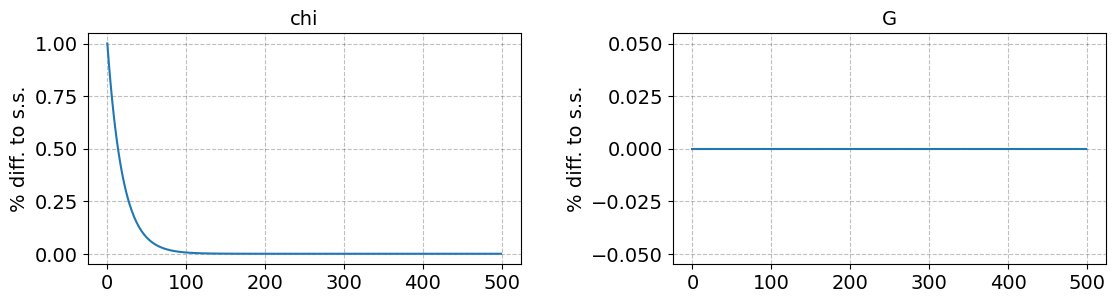


### varnames ###


/Users/nicolaibernsen/opt/anaconda3/lib/python3.9/site-packages/GEModelTools/figures.py:107: RuntimeWarning: divide by zero encountered in divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


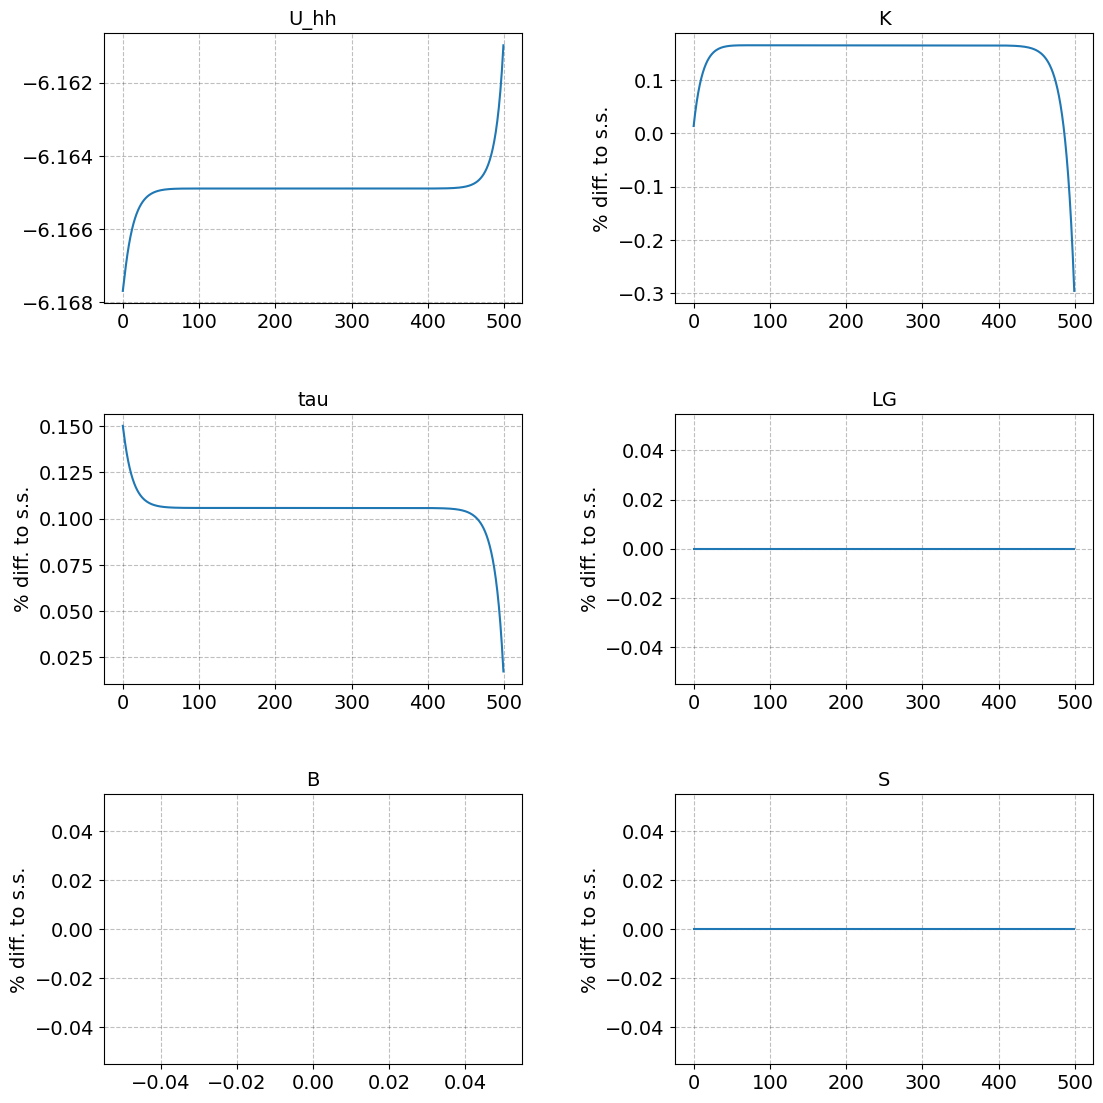


### tagets ###


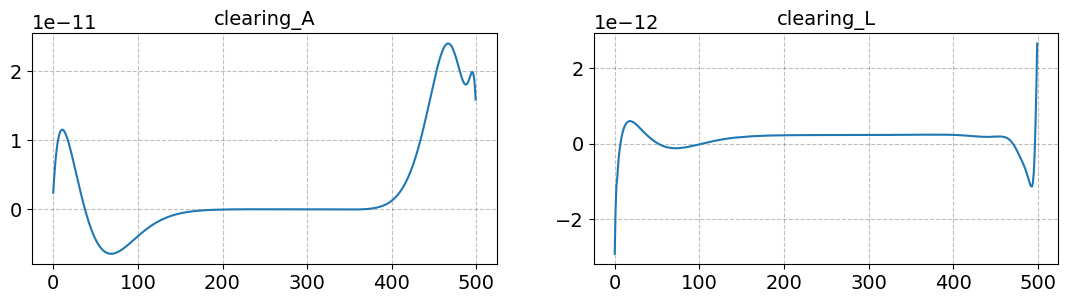

In [88]:
model.show_IRFs(varnames=['U_hh','K','tau','LG','B','S'],lvl_value=['U_hh'],ncols=2)

In [84]:
jump = ss.G*0.01
rho = 0.95
dG = jump*rho**np.arange(par.T)

K: terminal value is   2.04201882, but ss value is   2.04807877
LY: terminal value is   0.58151523, but ss value is   0.58167250
rK: terminal value is   0.12449836, but ss value is   0.12429497
w: terminal value is   1.02045574, but ss value is   1.02117101
Y: terminal value is   0.84772935, but ss value is   0.84855299
A: terminal value is   2.04201882, but ss value is   2.04807877
r: terminal value is   0.02449836, but ss value is   0.02429497
tau: terminal value is   0.57094503, but ss value is   0.57084668
wt: terminal value is   0.43783160, but ss value is   0.43823893
L: terminal value is   0.90141523, but ss value is   0.90157250
B: terminal value is -126.32052522, but ss value is   0.00000000
A_hh: terminal value is   2.04201882, but ss value is   2.04807877
C_hh: terminal value is   0.44464633, but ss value is   0.32384511
ELL_hh: terminal value is   0.96155929, but ss value is   0.96153341
L_hh: terminal value is   0.90141523, but ss value is   0.90157250
INC_hh: terminal val

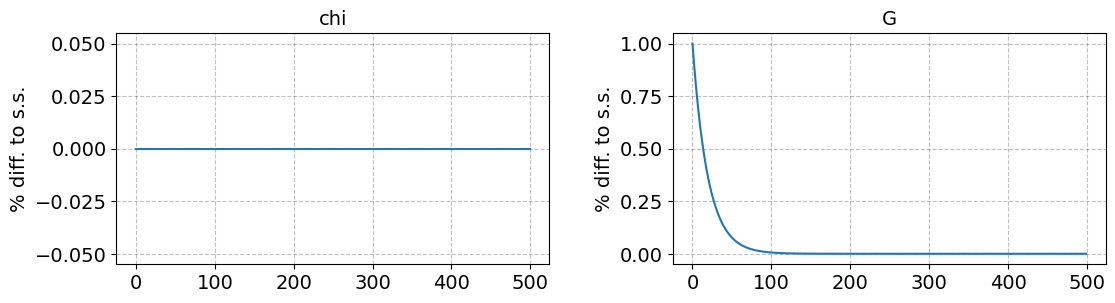


### varnames ###


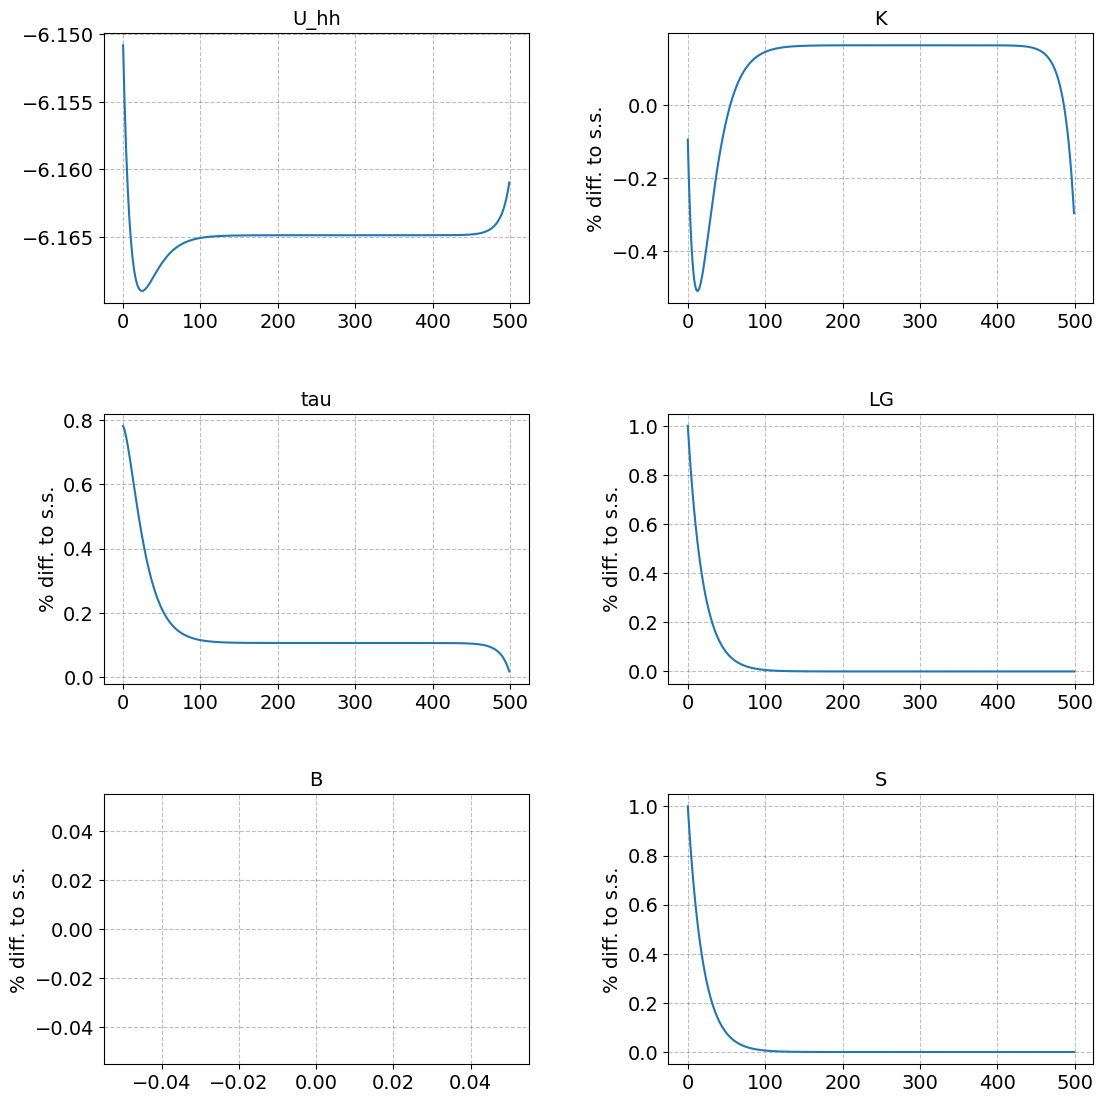


### tagets ###


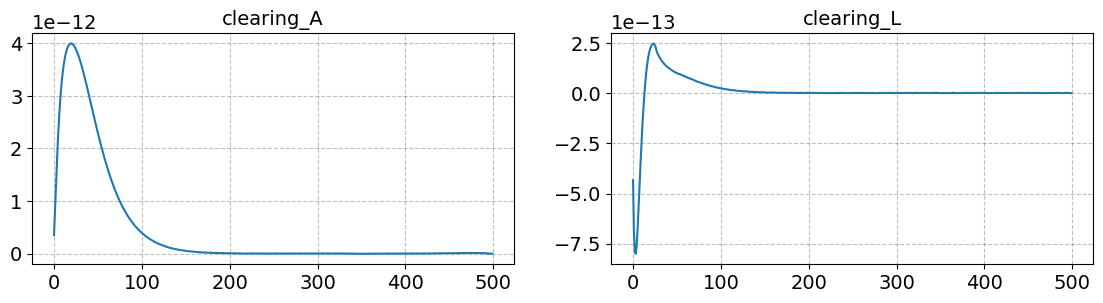

In [89]:
model.find_transition_path(shocks={'dG':dG},do_print=False)
model.show_IRFs(varnames=['U_hh','K','tau','LG','B','S'],lvl_value=['U_hh'],ncols=2)

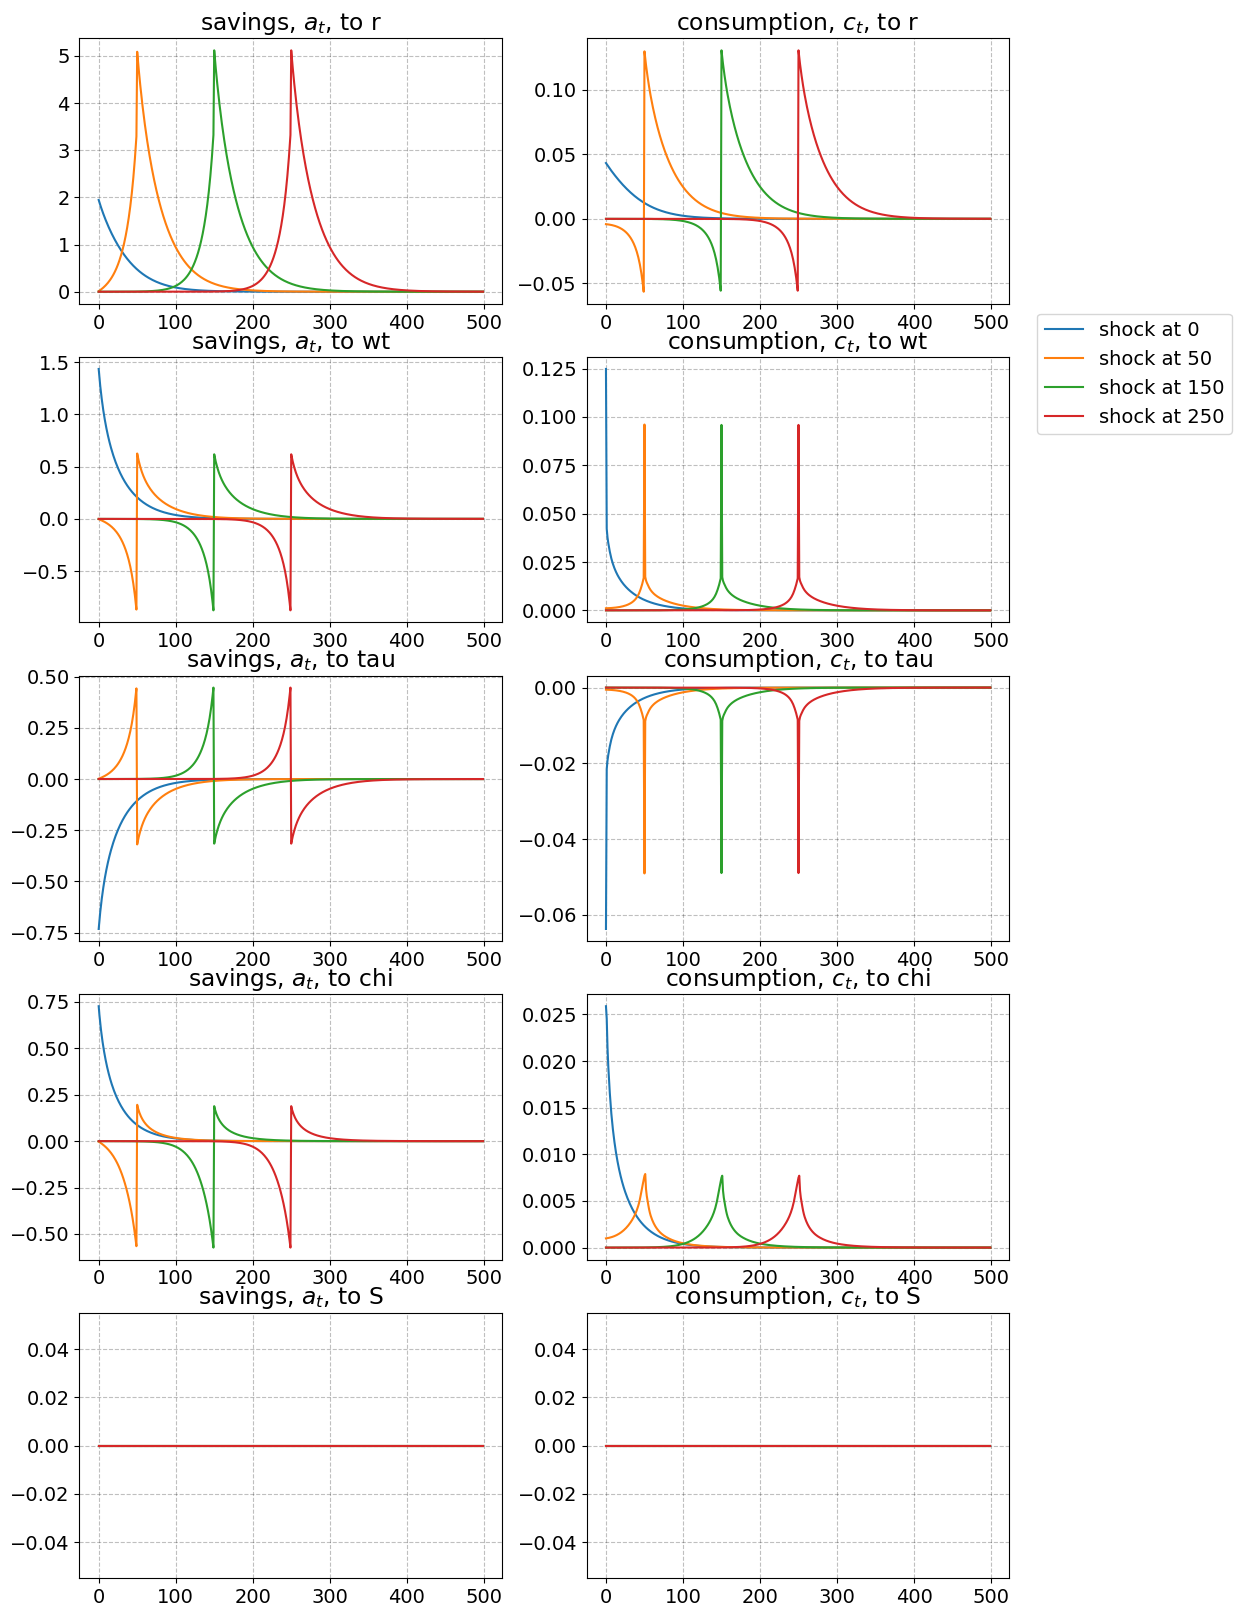

In [74]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
        
plt.show()

['Gamma_Y']
household problem solved along transition path in 1.3 secs
household problem simulated along transition in 0.1 secs

['chi']
household problem solved along transition path in 1.0 secs
household problem simulated along transition in 0.3 secs

['G']
household problem solved along transition path in 0.9 secs
household problem simulated along transition in 0.1 secs

['LG']
household problem solved along transition path in 1.4 secs
household problem simulated along transition in 0.1 secs

None
household problem solved along transition path in 1.1 secs
household problem simulated along transition in 0.0 secs

all
household problem solved along transition path in 1.3 secs
household problem simulated along transition in 0.5 secs



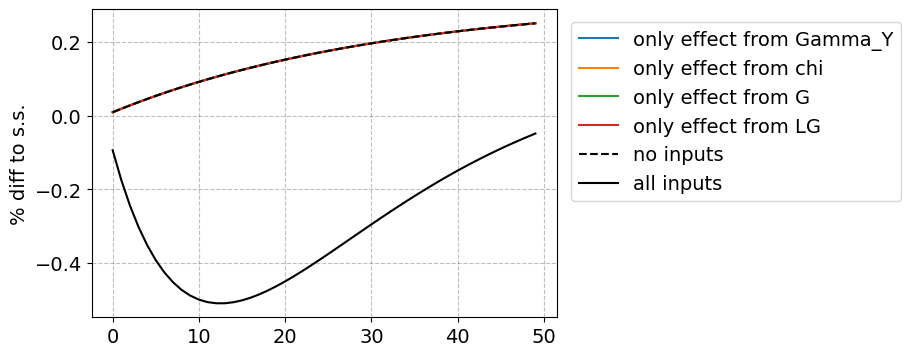

In [90]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['Gamma_Y'],['chi'],['G'],['LG'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99));

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.2 secs
household problem simulated along transition in 0.1 secs



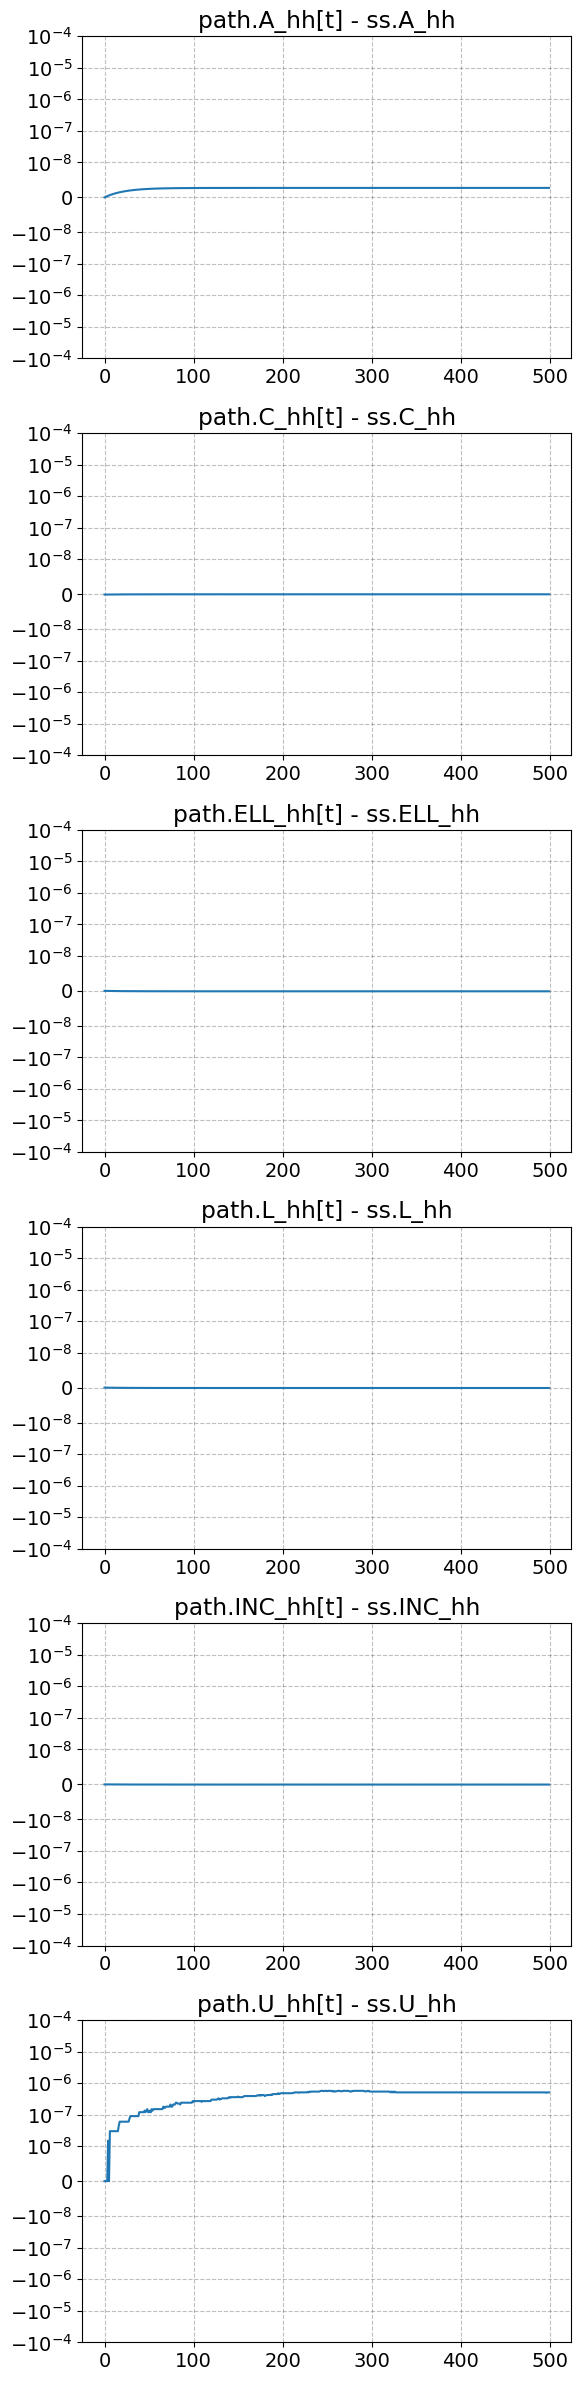

In [ ]:
model.test_hh_path()

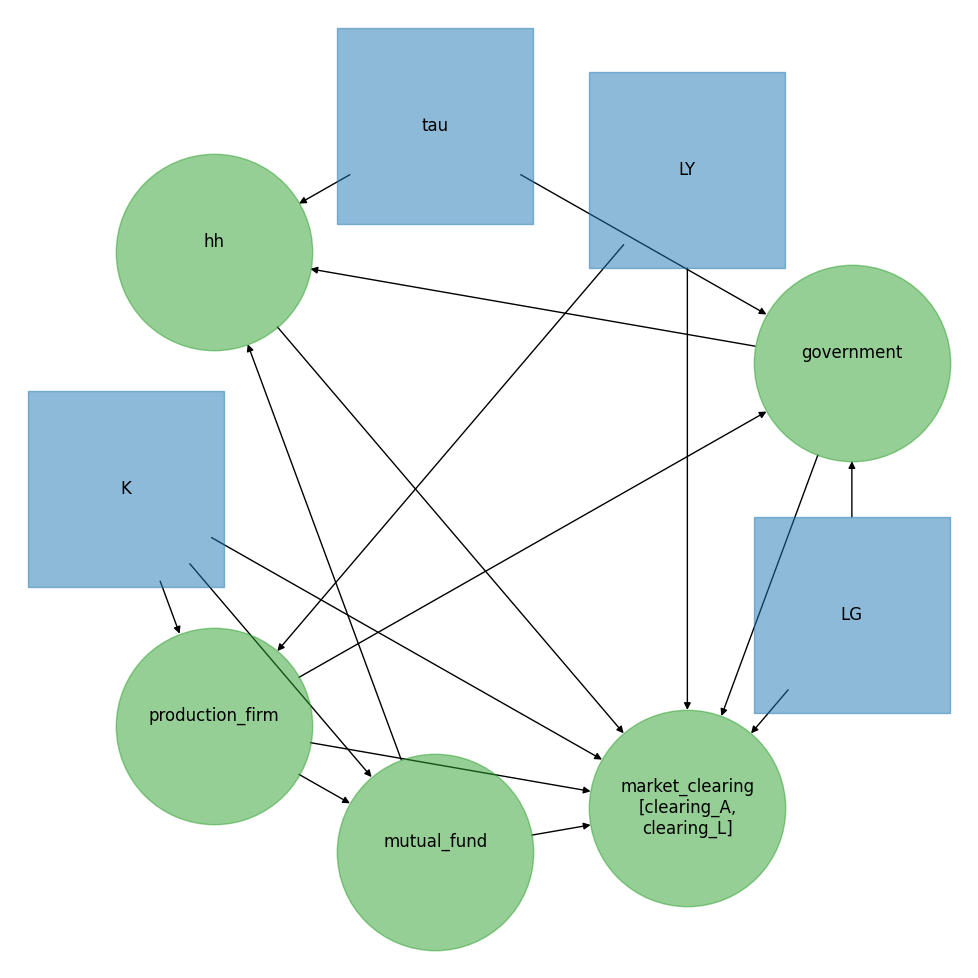

In [ ]:
model.draw_DAG(filename='DAG.png')

## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

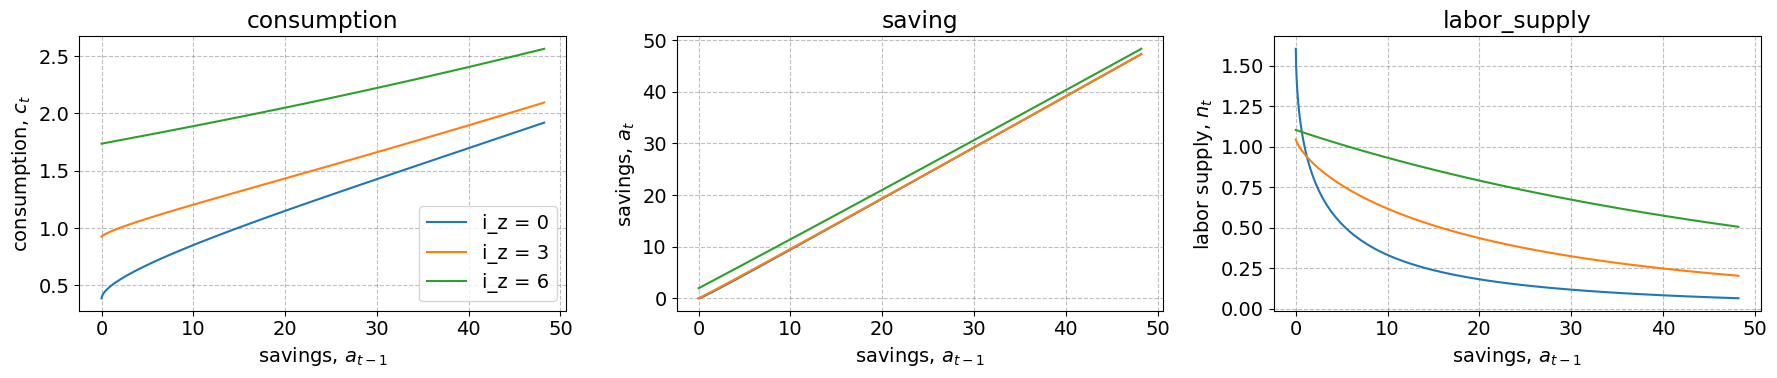

In [ ]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()
plt.show()